In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as ms
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
import pickle

transactions_feb = pd.read_pickle('Data/Processed/transactions_feb.pickle')
transactions_mar = pd.read_pickle('Data/Processed/transactions_mar.pickle')
transactions_apr = pd.read_pickle('Data/Processed/transactions_apr.pickle')
members_feb = pd.read_pickle('Data/Processed/members_feb.pickle')
members_mar = pd.read_pickle('Data/Processed/members_mar.pickle')
members_apr = pd.read_pickle('Data/Processed/members_apr.pickle')

(transactions_feb.shape, 
 transactions_mar.shape,
 transactions_apr.shape,
 members_feb.shape, 
 members_mar.shape,
 members_apr.shape,)

((879537, 58),
 (886500, 58),
 (907471, 58),
 (879537, 10),
 (886500, 10),
 (907471, 10))

In [5]:
train = pd.merge(transactions_feb, members_feb, on='msno')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879537 entries, 0 to 879536
Data columns (total 67 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   msno                                    879537 non-null  object        
 1   is_churn                                879537 non-null  float64       
 2   payment_method_id_last                  844812 non-null  object        
 3   payment_plan_days_last                  844812 non-null  float64       
 4   plan_list_price_last                    844812 non-null  float64       
 5   actual_amount_paid_last                 844812 non-null  float64       
 6   is_auto_renew_last                      844812 non-null  float64       
 7   transaction_date_last                   844812 non-null  float64       
 8   membership_expire_date_last             844812 non-null  float64       
 9   is_cancel_last                       

In [6]:
valid = pd.merge(transactions_mar, members_mar, on='msno')
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886500 entries, 0 to 886499
Data columns (total 67 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   msno                                    886500 non-null  object        
 1   is_churn                                886500 non-null  float64       
 2   payment_method_id_last                  848480 non-null  object        
 3   payment_plan_days_last                  848480 non-null  float64       
 4   plan_list_price_last                    848480 non-null  float64       
 5   actual_amount_paid_last                 848480 non-null  float64       
 6   is_auto_renew_last                      848480 non-null  float64       
 7   transaction_date_last                   848480 non-null  float64       
 8   membership_expire_date_last             848480 non-null  float64       
 9   is_cancel_last                       

In [7]:
test = pd.merge(transactions_apr, members_apr, on='msno')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907471 entries, 0 to 907470
Data columns (total 67 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   msno                                    907471 non-null  object        
 1   is_churn                                907471 non-null  int64         
 2   payment_method_id_last                  817540 non-null  object        
 3   payment_plan_days_last                  817540 non-null  float64       
 4   plan_list_price_last                    817540 non-null  float64       
 5   actual_amount_paid_last                 817540 non-null  float64       
 6   is_auto_renew_last                      817540 non-null  float64       
 7   transaction_date_last                   817540 non-null  float64       
 8   membership_expire_date_last             817540 non-null  float64       
 9   is_cancel_last                       

In [8]:
X_train = train.drop(['msno', 'transaction_date_dt_last', 'membership_expire_date_dt_last', 'is_churn'], axis=1)
y_train = train['is_churn']
X_valid = valid.drop(['msno', 'transaction_date_dt_last', 'membership_expire_date_dt_last', 'is_churn'], axis=1)
y_valid = valid['is_churn']
X_test = test.drop(['msno', 'transaction_date_dt_last', 'membership_expire_date_dt_last'], axis=1)

In [9]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((879537, 63), (886500, 63), (879537,), (886500,), (907471, 64))

In [10]:
y_train.mean(), y_valid.mean()

(0.03954466952498872, 0.04925549915397631)

In [11]:
X_train.head()

,payment_method_id_last,payment_plan_days_last,plan_list_price_last,actual_amount_paid_last,is_auto_renew_last,transaction_date_last,membership_expire_date_last,is_cancel_last,transaction_date_day_last,membership_expire_date_day_last,transaction_date_month_last,membership_expire_date_month_last,transaction_date_year_last,membership_expire_date_year_last,plan_duration_last,credit_last,transaction_credit_last,days_since_last_transaction_date_last,days_since_membership_expire_date_last,expired_and_not_auto_renew_last,payment_plan_days_sum,plan_list_price_sum,actual_amount_paid_sum,is_auto_renew_sum,is_cancel_sum,transaction_date_year_sum,membership_expire_date_year_sum,plan_duration_sum,credit_sum,expired_and_not_auto_renew_sum,overall_credit,paid_per_day,transactions_count,amount_paid_per_transaction,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,is_auto_renew_mean,is_cancel_mean,plan_duration_mean,credit_mean,days_since_last_transaction_date_mean,days_since_membership_expire_date_mean,expired_and_not_auto_renew_mean,payment_plan_days_dev,plan_list_price_dev,actual_amount_paid_dev,is_auto_renew_dev,is_cancel_dev,plan_duration_dev,credit_dev,days_since_last_transaction_date_dev,days_since_membership_expire_date_dev,expired_and_not_auto_renew_dev,city,bd,gender,registered_via,registration_init_time,member_for_days,registration_init_day,registration_init_month,registration_init_year
0,payment_method_id_41,30.0,149.0,149.0,1.0,20161213.0,20170113.0,0.0,Tue,Fri,Dec,Jan,2016.0,2017.0,31.0,0.0,even,50.0,19.0,0.0,690.0,3327.0,3456.0,24.0,0.0,48372.0,48374.0,731.0,129.0,0.0,credit,4.727770,24.0,144.0,28.75,138.625,144.0,1.0,0.0,30.458333,5.375,400.583333,370.125,0.0,1.25,10.375,5.0,0.0,0.0,0.541667,-5.375,-350.583333,-351.125,0.0,city_1,NaN,missing,registered_via_7,20140714.0,933.0,Mon,Jul,2014.0
1,payment_method_id_40,30.0,149.0,149.0,1.0,20161217.0,20170116.0,0.0,Sat,Mon,Dec,Jan,2016.0,2017.0,30.0,0.0,even,46.0,16.0,0.0,240.0,1192.0,1192.0,8.0,0.0,16128.0,16129.0,237.0,0.0,0.0,even,5.029536,8.0,149.0,30.00,149.000,149.0,1.0,0.0,29.625000,0.000,152.750000,123.125,0.0,0.00,0.000,0.0,0.0,0.0,0.375000,0.000,-106.750000,-107.125,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,payment_method_id_34,30.0,149.0,149.0,1.0,20161231.0,20170131.0,0.0,Sat,Tue,Dec,Jan,2016.0,2017.0,31.0,0.0,even,32.0,1.0,0.0,420.0,2086.0,2980.0,20.0,0.0,40312.0,40314.0,611.0,894.0,0.0,credit,4.877250,20.0,149.0,21.00,104.300,149.0,1.0,0.0,30.550000,44.700,325.200000,294.650,0.0,9.00,44.700,0.0,0.0,0.0,0.450000,-44.700,-293.200000,-293.650,0.0,city_other,31.0,male,registered_via_9,20060603.0,3896.0,Sat,Jun,2006.0
3,payment_method_id_34,30.0,149.0,149.0,1.0,20161231.0,20170131.0,0.0,Sat,Tue,Dec,Jan,2016.0,2017.0,31.0,0.0,even,32.0,1.0,0.0,420.0,2086.0,2980.0,20.0,0.0,40312.0,40314.0,611.0,894.0,0.0,credit,4.877250,20.0,149.0,21.00,104.300,149.0,1.0,0.0,30.550000,44.700,325.200000,294.650,0.0,9.00,44.700,0.0,0.0,0.0,0.450000,-44.700,-293.200000,-293.650,0.0,city_other,31.0,male,registered_via_9,20040330.0,4691.0,Tue,Mar,2004.0
4,payment_method_id_34,30.0,149.0,149.0,1.0,20161231.0,20170131.0,0.0,Sat,Tue,Dec,Jan,2016.0,2017.0,31.0,0.0,even,32.0,1.0,0.0,420.0,2086.0,2980.0,20.0,0.0,40312.0,40314.0,611.0,894.0,0.0,credit,4.877250,20.0,149.0,21.00,104.300,149.0,1.0,0.0,30.550000,44.700,325.200000,294.650,0.0,9.00,44.700,0.0,0.0,0.0,0.450000,-44.700,-293.200000,-293.650,0.0,city_other,29.0,male,registered_via_9,20080322.0,3238.0,Sat,Mar,2008.0


In [12]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

payment_method_id_last      34725
payment_plan_days_last      34725
plan_list_price_last        34725
actual_amount_paid_last     34725
is_auto_renew_last          34725
                            ...  
registration_init_time     110860
member_for_days            110860
registration_init_day      110860
registration_init_month    110860
registration_init_year     110860
Length: 63, dtype: int64


In [13]:
X_train.dtypes

payment_method_id_last      object
payment_plan_days_last     float64
plan_list_price_last       float64
actual_amount_paid_last    float64
is_auto_renew_last         float64
                            ...   
registration_init_time     float64
member_for_days            float64
registration_init_day       object
registration_init_month     object
registration_init_year     float64
Length: 63, dtype: object

In [14]:
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

In [15]:
categorical_columns

['payment_method_id_last',
 'transaction_date_day_last',
 'membership_expire_date_day_last',
 'transaction_date_month_last',
 'membership_expire_date_month_last',
 'transaction_credit_last',
 'overall_credit',
 'city',
 'gender',
 'registered_via',
 'registration_init_day',
 'registration_init_month']

In [16]:
numerical_columns

['payment_plan_days_last',
 'plan_list_price_last',
 'actual_amount_paid_last',
 'is_auto_renew_last',
 'transaction_date_last',
 'membership_expire_date_last',
 'is_cancel_last',
 'transaction_date_year_last',
 'membership_expire_date_year_last',
 'plan_duration_last',
 'credit_last',
 'days_since_last_transaction_date_last',
 'days_since_membership_expire_date_last',
 'expired_and_not_auto_renew_last',
 'payment_plan_days_sum',
 'plan_list_price_sum',
 'actual_amount_paid_sum',
 'is_auto_renew_sum',
 'is_cancel_sum',
 'transaction_date_year_sum',
 'membership_expire_date_year_sum',
 'plan_duration_sum',
 'credit_sum',
 'expired_and_not_auto_renew_sum',
 'paid_per_day',
 'transactions_count',
 'amount_paid_per_transaction',
 'payment_plan_days_mean',
 'plan_list_price_mean',
 'actual_amount_paid_mean',
 'is_auto_renew_mean',
 'is_cancel_mean',
 'plan_duration_mean',
 'credit_mean',
 'days_since_last_transaction_date_mean',
 'days_since_membership_expire_date_mean',
 'expired_and_not_a

In [17]:
len(categorical_columns) + len(numerical_columns)

63

In [18]:
m = (X_train == np.inf)
df = X_train.loc[m.any(axis=1), m.any(axis=0)]
df

,paid_per_day
34708,inf
40591,inf
44483,inf
72361,inf
91535,inf
111159,inf
131529,inf
142722,inf
147458,inf
183539,inf


In [19]:
pd.set_option('display.max_rows', None)
X_train[X_train['plan_duration_sum']==0][['paid_per_day', 'actual_amount_paid_sum', 'plan_duration_sum']]

,paid_per_day,actual_amount_paid_sum,plan_duration_sum
10359,NaN,0.0,0.0
34708,inf,100.0,0.0
40591,inf,149.0,0.0
44483,inf,99.0,0.0
67617,NaN,0.0,0.0
72361,inf,149.0,0.0
85370,NaN,0.0,0.0
91535,inf,149.0,0.0
111159,inf,129.0,0.0
124607,NaN,0.0,0.0


In [20]:
X_train['paid_per_day'] = X_train['paid_per_day'].replace([np.inf, -np.inf], np.nan)
X_train['paid_per_day'] = X_train['paid_per_day'].fillna(0)
X_valid['paid_per_day'] = X_valid['paid_per_day'].replace([np.inf, -np.inf], np.nan)
X_valid['paid_per_day'] = X_valid['paid_per_day'].fillna(0)
X_test['paid_per_day'] = X_test['paid_per_day'].replace([np.inf, -np.inf], np.nan)
X_test['paid_per_day'] = X_test['paid_per_day'].fillna(0)

In [21]:
# imputation
from sklearn.impute import SimpleImputer

# Imputation - categorical columns
imputer_most_freq = SimpleImputer(strategy='most_frequent')

X_train_filled = X_train.copy()
X_valid_filled = X_valid.copy()
X_test_filled = X_test.copy()
X_train_filled[categorical_columns] = pd.DataFrame(imputer_most_freq.fit_transform(X_train_filled[categorical_columns]))
X_valid_filled[categorical_columns] = pd.DataFrame(imputer_most_freq.transform(X_valid_filled[categorical_columns]))
X_test_filled[categorical_columns] = pd.DataFrame(imputer_most_freq.transform(X_test_filled[categorical_columns]))

# imputation removed column names, put them back
X_train_filled[categorical_columns].columns = X_train[categorical_columns].columns
X_valid_filled[categorical_columns].columns = X_valid[categorical_columns].columns
X_test_filled[categorical_columns].columns = X_test[categorical_columns].columns

# convert 'object' to category
X_train_filled[categorical_columns] = X_train_filled[categorical_columns].astype('category')
X_valid_filled[categorical_columns] = X_valid_filled[categorical_columns].astype('category')
X_test_filled[categorical_columns] = X_test_filled[categorical_columns].astype('category')

In [22]:
# Imputation - numerical columns
imputer_median = SimpleImputer(strategy='median')

X_train_filled = X_train_filled.copy()
X_valid_filled = X_valid_filled.copy()
X_test_filled = X_test_filled.copy()
X_train_filled[numerical_columns] = pd.DataFrame(imputer_median.fit_transform(X_train_filled[numerical_columns]))
X_valid_filled[numerical_columns] = pd.DataFrame(imputer_median.transform(X_valid_filled[numerical_columns]))
X_test_filled[numerical_columns] = pd.DataFrame(imputer_median.transform(X_test_filled[numerical_columns]))

# imputation removed column names, put them back
X_train_filled[numerical_columns].columns = X_train[numerical_columns].columns
X_valid_filled[numerical_columns].columns = X_valid[numerical_columns].columns
X_test_filled[numerical_columns].columns = X_test[numerical_columns].columns

## CatBoost

In [23]:
from catboost import CatBoostClassifier, Pool

cat_clf = CatBoostClassifier(loss_function='Logloss',
                             cat_features=categorical_columns,
                             verbose=True)
cat_clf.fit(X_train_filled, y_train, early_stopping_rounds=10)

Learning rate set to 0.186265
0:	learn: 0.4153453	total: 1.4s	remaining: 23m 20s
1:	learn: 0.2936352	total: 2.49s	remaining: 20m 42s
2:	learn: 0.2219032	total: 3.42s	remaining: 18m 58s
3:	learn: 0.1818317	total: 4.52s	remaining: 18m 44s
4:	learn: 0.1601766	total: 5.49s	remaining: 18m 12s
5:	learn: 0.1461113	total: 6.58s	remaining: 18m 9s
6:	learn: 0.1383632	total: 7.61s	remaining: 17m 59s
7:	learn: 0.1333744	total: 8.61s	remaining: 17m 47s
8:	learn: 0.1301960	total: 9.56s	remaining: 17m 32s
9:	learn: 0.1279978	total: 10.5s	remaining: 17m 21s
10:	learn: 0.1264148	total: 11.4s	remaining: 17m 4s
11:	learn: 0.1255330	total: 12.2s	remaining: 16m 48s
12:	learn: 0.1248627	total: 13.1s	remaining: 16m 34s
13:	learn: 0.1245277	total: 14s	remaining: 16m 25s
14:	learn: 0.1240146	total: 14.9s	remaining: 16m 17s
15:	learn: 0.1236966	total: 15.7s	remaining: 16m 6s
16:	learn: 0.1235416	total: 16.6s	remaining: 16m 2s
17:	learn: 0.1232816	total: 17.6s	remaining: 16m 1s
18:	learn: 0.1230537	total: 18.4s	

153:	learn: 0.1172670	total: 2m 20s	remaining: 12m 50s
154:	learn: 0.1172648	total: 2m 21s	remaining: 12m 49s
155:	learn: 0.1172480	total: 2m 22s	remaining: 12m 48s
156:	learn: 0.1172223	total: 2m 23s	remaining: 12m 48s
157:	learn: 0.1172036	total: 2m 23s	remaining: 12m 47s
158:	learn: 0.1171758	total: 2m 24s	remaining: 12m 46s
159:	learn: 0.1171701	total: 2m 25s	remaining: 12m 45s
160:	learn: 0.1171519	total: 2m 26s	remaining: 12m 44s
161:	learn: 0.1171480	total: 2m 27s	remaining: 12m 43s
162:	learn: 0.1171177	total: 2m 28s	remaining: 12m 42s
163:	learn: 0.1170968	total: 2m 29s	remaining: 12m 41s
164:	learn: 0.1170730	total: 2m 30s	remaining: 12m 40s
165:	learn: 0.1170684	total: 2m 31s	remaining: 12m 38s
166:	learn: 0.1170535	total: 2m 31s	remaining: 12m 38s
167:	learn: 0.1170480	total: 2m 32s	remaining: 12m 36s
168:	learn: 0.1170339	total: 2m 33s	remaining: 12m 35s
169:	learn: 0.1170296	total: 2m 34s	remaining: 12m 34s
170:	learn: 0.1170064	total: 2m 35s	remaining: 12m 33s
171:	learn

304:	learn: 0.1155172	total: 4m 33s	remaining: 10m 24s
305:	learn: 0.1155003	total: 4m 34s	remaining: 10m 23s
306:	learn: 0.1154735	total: 4m 35s	remaining: 10m 22s
307:	learn: 0.1154609	total: 4m 36s	remaining: 10m 21s
308:	learn: 0.1154575	total: 4m 37s	remaining: 10m 20s
309:	learn: 0.1154460	total: 4m 38s	remaining: 10m 19s
310:	learn: 0.1154287	total: 4m 39s	remaining: 10m 18s
311:	learn: 0.1154232	total: 4m 40s	remaining: 10m 17s
312:	learn: 0.1154093	total: 4m 40s	remaining: 10m 16s
313:	learn: 0.1154039	total: 4m 41s	remaining: 10m 15s
314:	learn: 0.1153893	total: 4m 42s	remaining: 10m 14s
315:	learn: 0.1153852	total: 4m 43s	remaining: 10m 13s
316:	learn: 0.1153736	total: 4m 44s	remaining: 10m 12s
317:	learn: 0.1153701	total: 4m 45s	remaining: 10m 11s
318:	learn: 0.1153554	total: 4m 46s	remaining: 10m 11s
319:	learn: 0.1153493	total: 4m 47s	remaining: 10m 10s
320:	learn: 0.1153432	total: 4m 47s	remaining: 10m 9s
321:	learn: 0.1153371	total: 4m 48s	remaining: 10m 8s
322:	learn: 

457:	learn: 0.1140720	total: 6m 51s	remaining: 8m 6s
458:	learn: 0.1140559	total: 6m 52s	remaining: 8m 5s
459:	learn: 0.1140523	total: 6m 53s	remaining: 8m 4s
460:	learn: 0.1140478	total: 6m 53s	remaining: 8m 3s
461:	learn: 0.1140326	total: 6m 54s	remaining: 8m 3s
462:	learn: 0.1140304	total: 6m 55s	remaining: 8m 1s
463:	learn: 0.1140241	total: 6m 56s	remaining: 8m 1s
464:	learn: 0.1140154	total: 6m 57s	remaining: 8m
465:	learn: 0.1140034	total: 6m 58s	remaining: 7m 59s
466:	learn: 0.1139917	total: 6m 59s	remaining: 7m 58s
467:	learn: 0.1139805	total: 7m	remaining: 7m 57s
468:	learn: 0.1139668	total: 7m 1s	remaining: 7m 56s
469:	learn: 0.1139656	total: 7m 2s	remaining: 7m 55s
470:	learn: 0.1139639	total: 7m 2s	remaining: 7m 54s
471:	learn: 0.1139496	total: 7m 3s	remaining: 7m 54s
472:	learn: 0.1139414	total: 7m 4s	remaining: 7m 53s
473:	learn: 0.1139321	total: 7m 5s	remaining: 7m 52s
474:	learn: 0.1139244	total: 7m 6s	remaining: 7m 51s
475:	learn: 0.1139185	total: 7m 7s	remaining: 7m 5

611:	learn: 0.1128749	total: 9m 6s	remaining: 5m 46s
612:	learn: 0.1128722	total: 9m 7s	remaining: 5m 45s
613:	learn: 0.1128649	total: 9m 8s	remaining: 5m 44s
614:	learn: 0.1128595	total: 9m 9s	remaining: 5m 44s
615:	learn: 0.1128505	total: 9m 10s	remaining: 5m 43s
616:	learn: 0.1128142	total: 9m 11s	remaining: 5m 42s
617:	learn: 0.1128110	total: 9m 12s	remaining: 5m 41s
618:	learn: 0.1128057	total: 9m 13s	remaining: 5m 40s
619:	learn: 0.1127951	total: 9m 13s	remaining: 5m 39s
620:	learn: 0.1127829	total: 9m 14s	remaining: 5m 38s
621:	learn: 0.1127798	total: 9m 15s	remaining: 5m 37s
622:	learn: 0.1127641	total: 9m 16s	remaining: 5m 36s
623:	learn: 0.1127581	total: 9m 17s	remaining: 5m 35s
624:	learn: 0.1127547	total: 9m 18s	remaining: 5m 34s
625:	learn: 0.1127491	total: 9m 19s	remaining: 5m 34s
626:	learn: 0.1127442	total: 9m 20s	remaining: 5m 33s
627:	learn: 0.1127376	total: 9m 20s	remaining: 5m 32s
628:	learn: 0.1127300	total: 9m 21s	remaining: 5m 31s
629:	learn: 0.1127157	total: 9m 

763:	learn: 0.1119050	total: 11m 23s	remaining: 3m 31s
764:	learn: 0.1119004	total: 11m 24s	remaining: 3m 30s
765:	learn: 0.1118910	total: 11m 25s	remaining: 3m 29s
766:	learn: 0.1118855	total: 11m 25s	remaining: 3m 28s
767:	learn: 0.1118852	total: 11m 26s	remaining: 3m 27s
768:	learn: 0.1118765	total: 11m 27s	remaining: 3m 26s
769:	learn: 0.1118679	total: 11m 28s	remaining: 3m 25s
770:	learn: 0.1118590	total: 11m 29s	remaining: 3m 24s
771:	learn: 0.1118539	total: 11m 29s	remaining: 3m 23s
772:	learn: 0.1118442	total: 11m 30s	remaining: 3m 22s
773:	learn: 0.1118348	total: 11m 31s	remaining: 3m 21s
774:	learn: 0.1118238	total: 11m 32s	remaining: 3m 21s
775:	learn: 0.1118166	total: 11m 33s	remaining: 3m 20s
776:	learn: 0.1118133	total: 11m 34s	remaining: 3m 19s
777:	learn: 0.1118093	total: 11m 35s	remaining: 3m 18s
778:	learn: 0.1118033	total: 11m 36s	remaining: 3m 17s
779:	learn: 0.1118029	total: 11m 37s	remaining: 3m 16s
780:	learn: 0.1117926	total: 11m 37s	remaining: 3m 15s
781:	learn

913:	learn: 0.1109384	total: 13m 37s	remaining: 1m 16s
914:	learn: 0.1109328	total: 13m 38s	remaining: 1m 16s
915:	learn: 0.1109171	total: 13m 39s	remaining: 1m 15s
916:	learn: 0.1109115	total: 13m 40s	remaining: 1m 14s
917:	learn: 0.1109075	total: 13m 41s	remaining: 1m 13s
918:	learn: 0.1109058	total: 13m 42s	remaining: 1m 12s
919:	learn: 0.1108989	total: 13m 43s	remaining: 1m 11s
920:	learn: 0.1108930	total: 13m 44s	remaining: 1m 10s
921:	learn: 0.1108834	total: 13m 45s	remaining: 1m 9s
922:	learn: 0.1108775	total: 13m 46s	remaining: 1m 8s
923:	learn: 0.1108633	total: 13m 47s	remaining: 1m 8s
924:	learn: 0.1108592	total: 13m 48s	remaining: 1m 7s
925:	learn: 0.1108562	total: 13m 49s	remaining: 1m 6s
926:	learn: 0.1108407	total: 13m 50s	remaining: 1m 5s
927:	learn: 0.1108358	total: 13m 51s	remaining: 1m 4s
928:	learn: 0.1108287	total: 13m 52s	remaining: 1m 3s
929:	learn: 0.1108194	total: 13m 53s	remaining: 1m 2s
930:	learn: 0.1108162	total: 13m 54s	remaining: 1m 1s
931:	learn: 0.110806

In [24]:
y_pred_cat = cat_clf.predict(X_valid_filled)
y_pred_proba_cat = cat_clf.predict_proba(X_valid_filled)
y_pred_train_cat = cat_clf.predict(X_train_filled)
y_pred_proba_train_cat = cat_clf.predict_proba(X_train_filled)
print('CatBoost Classifier log-loss train set: ' + str(log_loss(y_train, y_pred_proba_train_cat[:,1])))
print('CatBoost Classifier log-loss validation set: ' + str(log_loss(y_valid, y_pred_proba_cat[:,1])))

CatBoost Classifier log-loss train set: 0.11141057799952324
CatBoost Classifier log-loss validation set: 0.14436037317792483


### One Hot Encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe_enc = OneHotEncoder(drop='first')
ohe_enc.fit(X_train_filled[categorical_columns])
feature_names = ohe_enc.get_feature_names(categorical_columns)
X_train_filled_ohe = ohe_enc.transform(X_train_filled[categorical_columns])
X_train_filled_ohe = pd.DataFrame(X_train_filled_ohe.todense())
X_train_filled_ohe.columns = feature_names
X_train_filled_ohe.head()

,payment_method_id_last_payment_method_id_33,payment_method_id_last_payment_method_id_34,payment_method_id_last_payment_method_id_36,payment_method_id_last_payment_method_id_37,payment_method_id_last_payment_method_id_38,payment_method_id_last_payment_method_id_40,payment_method_id_last_payment_method_id_41,payment_method_id_last_payment_method_id_other,transaction_date_day_last_Mon,transaction_date_day_last_Sat,transaction_date_day_last_Sun,transaction_date_day_last_Thu,transaction_date_day_last_Tue,transaction_date_day_last_Wed,membership_expire_date_day_last_Mon,membership_expire_date_day_last_Sat,membership_expire_date_day_last_Sun,membership_expire_date_day_last_Thu,membership_expire_date_day_last_Tue,membership_expire_date_day_last_Wed,transaction_date_month_last_Aug,transaction_date_month_last_Dec,transaction_date_month_last_Feb,transaction_date_month_last_Jan,transaction_date_month_last_Jul,transaction_date_month_last_Jun,transaction_date_month_last_Mar,transaction_date_month_last_May,transaction_date_month_last_Nov,transaction_date_month_last_Oct,transaction_date_month_last_Sep,membership_expire_date_month_last_Aug,membership_expire_date_month_last_Dec,membership_expire_date_month_last_Feb,membership_expire_date_month_last_Jan,membership_expire_date_month_last_Jul,membership_expire_date_month_last_Jun,membership_expire_date_month_last_Mar,membership_expire_date_month_last_May,membership_expire_date_month_last_Nov,membership_expire_date_month_last_Oct,membership_expire_date_month_last_Sep,transaction_credit_last_debit,transaction_credit_last_even,overall_credit_debit,overall_credit_even,city_city_13,city_city_4,city_city_5,city_city_other,gender_male,gender_missing,registered_via_registered_via_3,registered_via_registered_via_4,registered_via_registered_via_7,registered_via_registered_via_9,registration_init_day_Mon,registration_init_day_Sat,registration_init_day_Sun,registration_init_day_Thu,registration_init_day_Tue,registration_init_day_Wed,registration_init_month_Aug,registration_init_month_Dec,registration_init_month_Feb,registration_init_month_Jan,registration_init_month_Jul,registration_init_month_Jun,registration_init_month_Mar,registration_init_month_May,registration_init_month_Nov,registration_init_month_Oct,registration_init_month_Sep
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
X_valid_filled_ohe = ohe_enc.transform(X_valid_filled[categorical_columns])
X_valid_filled_ohe = pd.DataFrame(X_valid_filled_ohe.todense())
X_valid_filled_ohe.columns = feature_names
X_valid_filled_ohe.head()

,payment_method_id_last_payment_method_id_33,payment_method_id_last_payment_method_id_34,payment_method_id_last_payment_method_id_36,payment_method_id_last_payment_method_id_37,payment_method_id_last_payment_method_id_38,payment_method_id_last_payment_method_id_40,payment_method_id_last_payment_method_id_41,payment_method_id_last_payment_method_id_other,transaction_date_day_last_Mon,transaction_date_day_last_Sat,transaction_date_day_last_Sun,transaction_date_day_last_Thu,transaction_date_day_last_Tue,transaction_date_day_last_Wed,membership_expire_date_day_last_Mon,membership_expire_date_day_last_Sat,membership_expire_date_day_last_Sun,membership_expire_date_day_last_Thu,membership_expire_date_day_last_Tue,membership_expire_date_day_last_Wed,transaction_date_month_last_Aug,transaction_date_month_last_Dec,transaction_date_month_last_Feb,transaction_date_month_last_Jan,transaction_date_month_last_Jul,transaction_date_month_last_Jun,transaction_date_month_last_Mar,transaction_date_month_last_May,transaction_date_month_last_Nov,transaction_date_month_last_Oct,transaction_date_month_last_Sep,membership_expire_date_month_last_Aug,membership_expire_date_month_last_Dec,membership_expire_date_month_last_Feb,membership_expire_date_month_last_Jan,membership_expire_date_month_last_Jul,membership_expire_date_month_last_Jun,membership_expire_date_month_last_Mar,membership_expire_date_month_last_May,membership_expire_date_month_last_Nov,membership_expire_date_month_last_Oct,membership_expire_date_month_last_Sep,transaction_credit_last_debit,transaction_credit_last_even,overall_credit_debit,overall_credit_even,city_city_13,city_city_4,city_city_5,city_city_other,gender_male,gender_missing,registered_via_registered_via_3,registered_via_registered_via_4,registered_via_registered_via_7,registered_via_registered_via_9,registration_init_day_Mon,registration_init_day_Sat,registration_init_day_Sun,registration_init_day_Thu,registration_init_day_Tue,registration_init_day_Wed,registration_init_month_Aug,registration_init_month_Dec,registration_init_month_Feb,registration_init_month_Jan,registration_init_month_Jul,registration_init_month_Jun,registration_init_month_Mar,registration_init_month_May,registration_init_month_Nov,registration_init_month_Oct,registration_init_month_Sep
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
X_test_filled_ohe = ohe_enc.transform(X_test_filled[categorical_columns])
X_test_filled_ohe = pd.DataFrame(X_test_filled_ohe.todense())
X_test_filled_ohe.columns = feature_names
X_test_filled_ohe.head()

,payment_method_id_last_payment_method_id_33,payment_method_id_last_payment_method_id_34,payment_method_id_last_payment_method_id_36,payment_method_id_last_payment_method_id_37,payment_method_id_last_payment_method_id_38,payment_method_id_last_payment_method_id_40,payment_method_id_last_payment_method_id_41,payment_method_id_last_payment_method_id_other,transaction_date_day_last_Mon,transaction_date_day_last_Sat,transaction_date_day_last_Sun,transaction_date_day_last_Thu,transaction_date_day_last_Tue,transaction_date_day_last_Wed,membership_expire_date_day_last_Mon,membership_expire_date_day_last_Sat,membership_expire_date_day_last_Sun,membership_expire_date_day_last_Thu,membership_expire_date_day_last_Tue,membership_expire_date_day_last_Wed,transaction_date_month_last_Aug,transaction_date_month_last_Dec,transaction_date_month_last_Feb,transaction_date_month_last_Jan,transaction_date_month_last_Jul,transaction_date_month_last_Jun,transaction_date_month_last_Mar,transaction_date_month_last_May,transaction_date_month_last_Nov,transaction_date_month_last_Oct,transaction_date_month_last_Sep,membership_expire_date_month_last_Aug,membership_expire_date_month_last_Dec,membership_expire_date_month_last_Feb,membership_expire_date_month_last_Jan,membership_expire_date_month_last_Jul,membership_expire_date_month_last_Jun,membership_expire_date_month_last_Mar,membership_expire_date_month_last_May,membership_expire_date_month_last_Nov,membership_expire_date_month_last_Oct,membership_expire_date_month_last_Sep,transaction_credit_last_debit,transaction_credit_last_even,overall_credit_debit,overall_credit_even,city_city_13,city_city_4,city_city_5,city_city_other,gender_male,gender_missing,registered_via_registered_via_3,registered_via_registered_via_4,registered_via_registered_via_7,registered_via_registered_via_9,registration_init_day_Mon,registration_init_day_Sat,registration_init_day_Sun,registration_init_day_Thu,registration_init_day_Tue,registration_init_day_Wed,registration_init_month_Aug,registration_init_month_Dec,registration_init_month_Feb,registration_init_month_Jan,registration_init_month_Jul,registration_init_month_Jun,registration_init_month_Mar,registration_init_month_May,registration_init_month_Nov,registration_init_month_Oct,registration_init_month_Sep
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_train_filled.drop(categorical_columns, axis=1, inplace=True)
X_valid_filled.drop(categorical_columns, axis=1, inplace=True)
X_test_filled.drop(categorical_columns, axis=1, inplace=True)
X_train_filled = pd.concat([X_train_filled, X_train_filled_ohe], axis=1)
X_valid_filled = pd.concat([X_valid_filled, X_valid_filled_ohe], axis=1)
X_test_filled = pd.concat([X_test_filled, X_test_filled_ohe], axis=1)

In [29]:
X_train_filled.shape, y_train.shape, X_valid_filled.shape, y_valid.shape, X_test_filled.shape

((879537, 124), (879537,), (886500, 124), (886500,), (907471, 125))

In [30]:
X_train_filled.isnull().sum().sum(), \
X_valid_filled.isnull().sum().sum(), \
X_test_filled.isnull().sum().sum()

(0, 0, 0)

In [31]:
X_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879537 entries, 0 to 879536
Columns: 124 entries, payment_plan_days_last to registration_init_month_Sep
dtypes: float64(124)
memory usage: 838.8 MB


In [32]:
a = (len(y_train)- y_train.sum())/y_train.sum()
a, np.sqrt(a)

(24.287858313446996, 4.928271331151218)

## CatBoost with OHE

In [34]:
cat_clf = CatBoostClassifier(loss_function='Logloss',
                             verbose=True)
cat_clf.fit(X_train_filled, y_train, early_stopping_rounds=10)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.186265
0:	learn: 0.4238169	total: 148ms	remaining: 2m 27s
1:	learn: 0.2850845	total: 316ms	remaining: 2m 37s
2:	learn: 0.2152375	total: 489ms	remaining: 2m 42s
3:	learn: 0.1795778	total: 641ms	remaining: 2m 39s
4:	learn: 0.1574450	total: 808ms	remaining: 2m 40s
5:	learn: 0.1444392	total: 974ms	remaining: 2m 41s
6:	learn: 0.1375890	total: 1.15s	remaining: 2m 42s
7:	learn: 0.1340939	total: 1.3s	remaining: 2m 40s
8:	learn: 0.1312902	total: 1.48s	remaining: 2m 42s
9:	learn: 0.1292270	total: 1.67s	remaining: 2m 45s
10:	learn: 0.1281806	total: 1.82s	remaining: 2m 44s
11:	learn: 0.1270957	total: 1.99s	remaining: 2m 43s
12:	learn: 0.1262120	total: 2.13s	remaining: 2m 42s
13:	learn: 0.1253546	total: 2.31s	remaining: 2m 42s
14:	learn: 0.1245947	total: 2.48s	remaining: 2m 43s
15:	learn: 0.1242214	total: 2.66s	remaining: 2m 43s
16:	learn: 0.1240461	total: 2.8s	remaining: 2m 41s
17:	learn: 0.1238270	total: 2.95s	remaining: 2m 40s
18:	learn: 0.1236320	total: 3.11s	remaining: 2

158:	learn: 0.1172351	total: 24s	remaining: 2m 6s
159:	learn: 0.1172125	total: 24.1s	remaining: 2m 6s
160:	learn: 0.1171960	total: 24.3s	remaining: 2m 6s
161:	learn: 0.1171874	total: 24.4s	remaining: 2m 6s
162:	learn: 0.1171776	total: 24.5s	remaining: 2m 5s
163:	learn: 0.1171596	total: 24.7s	remaining: 2m 5s
164:	learn: 0.1171444	total: 24.8s	remaining: 2m 5s
165:	learn: 0.1171372	total: 24.9s	remaining: 2m 5s
166:	learn: 0.1171280	total: 25.1s	remaining: 2m 5s
167:	learn: 0.1171120	total: 25.2s	remaining: 2m 4s
168:	learn: 0.1170939	total: 25.4s	remaining: 2m 4s
169:	learn: 0.1170817	total: 25.5s	remaining: 2m 4s
170:	learn: 0.1170676	total: 25.7s	remaining: 2m 4s
171:	learn: 0.1170541	total: 25.8s	remaining: 2m 4s
172:	learn: 0.1170416	total: 26s	remaining: 2m 4s
173:	learn: 0.1170250	total: 26.1s	remaining: 2m 4s
174:	learn: 0.1170100	total: 26.3s	remaining: 2m 3s
175:	learn: 0.1170004	total: 26.4s	remaining: 2m 3s
176:	learn: 0.1169893	total: 26.5s	remaining: 2m 3s
177:	learn: 0.11

316:	learn: 0.1152346	total: 46.6s	remaining: 1m 40s
317:	learn: 0.1152249	total: 46.8s	remaining: 1m 40s
318:	learn: 0.1152074	total: 46.9s	remaining: 1m 40s
319:	learn: 0.1151942	total: 47s	remaining: 1m 39s
320:	learn: 0.1151872	total: 47.2s	remaining: 1m 39s
321:	learn: 0.1151734	total: 47.3s	remaining: 1m 39s
322:	learn: 0.1151591	total: 47.5s	remaining: 1m 39s
323:	learn: 0.1151478	total: 47.6s	remaining: 1m 39s
324:	learn: 0.1151350	total: 47.8s	remaining: 1m 39s
325:	learn: 0.1151179	total: 47.9s	remaining: 1m 39s
326:	learn: 0.1151085	total: 48.1s	remaining: 1m 38s
327:	learn: 0.1151029	total: 48.2s	remaining: 1m 38s
328:	learn: 0.1150847	total: 48.3s	remaining: 1m 38s
329:	learn: 0.1150739	total: 48.5s	remaining: 1m 38s
330:	learn: 0.1150627	total: 48.6s	remaining: 1m 38s
331:	learn: 0.1150501	total: 48.8s	remaining: 1m 38s
332:	learn: 0.1150409	total: 48.9s	remaining: 1m 37s
333:	learn: 0.1150293	total: 49s	remaining: 1m 37s
334:	learn: 0.1150189	total: 49.2s	remaining: 1m 3

472:	learn: 0.1135750	total: 1m 9s	remaining: 1m 16s
473:	learn: 0.1135622	total: 1m 9s	remaining: 1m 16s
474:	learn: 0.1135511	total: 1m 9s	remaining: 1m 16s
475:	learn: 0.1135433	total: 1m 9s	remaining: 1m 16s
476:	learn: 0.1135311	total: 1m 9s	remaining: 1m 16s
477:	learn: 0.1135256	total: 1m 9s	remaining: 1m 16s
478:	learn: 0.1135175	total: 1m 9s	remaining: 1m 16s
479:	learn: 0.1135058	total: 1m 10s	remaining: 1m 15s
480:	learn: 0.1134912	total: 1m 10s	remaining: 1m 15s
481:	learn: 0.1134788	total: 1m 10s	remaining: 1m 15s
482:	learn: 0.1134672	total: 1m 10s	remaining: 1m 15s
483:	learn: 0.1134662	total: 1m 10s	remaining: 1m 15s
484:	learn: 0.1134553	total: 1m 10s	remaining: 1m 15s
485:	learn: 0.1134447	total: 1m 10s	remaining: 1m 15s
486:	learn: 0.1134383	total: 1m 11s	remaining: 1m 14s
487:	learn: 0.1134265	total: 1m 11s	remaining: 1m 14s
488:	learn: 0.1134168	total: 1m 11s	remaining: 1m 14s
489:	learn: 0.1134056	total: 1m 11s	remaining: 1m 14s
490:	learn: 0.1133971	total: 1m 11s

628:	learn: 0.1122545	total: 1m 31s	remaining: 53.9s
629:	learn: 0.1122505	total: 1m 31s	remaining: 53.8s
630:	learn: 0.1122381	total: 1m 31s	remaining: 53.6s
631:	learn: 0.1122331	total: 1m 31s	remaining: 53.5s
632:	learn: 0.1122222	total: 1m 32s	remaining: 53.3s
633:	learn: 0.1122128	total: 1m 32s	remaining: 53.2s
634:	learn: 0.1122023	total: 1m 32s	remaining: 53.1s
635:	learn: 0.1121976	total: 1m 32s	remaining: 52.9s
636:	learn: 0.1121911	total: 1m 32s	remaining: 52.8s
637:	learn: 0.1121863	total: 1m 32s	remaining: 52.6s
638:	learn: 0.1121807	total: 1m 32s	remaining: 52.5s
639:	learn: 0.1121649	total: 1m 33s	remaining: 52.3s
640:	learn: 0.1121570	total: 1m 33s	remaining: 52.2s
641:	learn: 0.1121506	total: 1m 33s	remaining: 52.1s
642:	learn: 0.1121417	total: 1m 33s	remaining: 51.9s
643:	learn: 0.1121348	total: 1m 33s	remaining: 51.8s
644:	learn: 0.1121244	total: 1m 33s	remaining: 51.6s
645:	learn: 0.1121170	total: 1m 33s	remaining: 51.5s
646:	learn: 0.1121104	total: 1m 34s	remaining:

784:	learn: 0.1110471	total: 1m 53s	remaining: 31.2s
785:	learn: 0.1110399	total: 1m 54s	remaining: 31.1s
786:	learn: 0.1110338	total: 1m 54s	remaining: 30.9s
787:	learn: 0.1110272	total: 1m 54s	remaining: 30.8s
788:	learn: 0.1110197	total: 1m 54s	remaining: 30.6s
789:	learn: 0.1110098	total: 1m 54s	remaining: 30.5s
790:	learn: 0.1109929	total: 1m 54s	remaining: 30.3s
791:	learn: 0.1109837	total: 1m 54s	remaining: 30.2s
792:	learn: 0.1109754	total: 1m 55s	remaining: 30s
793:	learn: 0.1109698	total: 1m 55s	remaining: 29.9s
794:	learn: 0.1109643	total: 1m 55s	remaining: 29.7s
795:	learn: 0.1109593	total: 1m 55s	remaining: 29.6s
796:	learn: 0.1109536	total: 1m 55s	remaining: 29.4s
797:	learn: 0.1109502	total: 1m 55s	remaining: 29.3s
798:	learn: 0.1109452	total: 1m 55s	remaining: 29.2s
799:	learn: 0.1109351	total: 1m 56s	remaining: 29s
800:	learn: 0.1109284	total: 1m 56s	remaining: 28.9s
801:	learn: 0.1109179	total: 1m 56s	remaining: 28.7s
802:	learn: 0.1109000	total: 1m 56s	remaining: 28.

941:	learn: 0.1099161	total: 2m 16s	remaining: 8.41s
942:	learn: 0.1099072	total: 2m 16s	remaining: 8.27s
943:	learn: 0.1099034	total: 2m 16s	remaining: 8.12s
944:	learn: 0.1098954	total: 2m 17s	remaining: 7.98s
945:	learn: 0.1098897	total: 2m 17s	remaining: 7.83s
946:	learn: 0.1098829	total: 2m 17s	remaining: 7.68s
947:	learn: 0.1098774	total: 2m 17s	remaining: 7.54s
948:	learn: 0.1098701	total: 2m 17s	remaining: 7.39s
949:	learn: 0.1098605	total: 2m 17s	remaining: 7.25s
950:	learn: 0.1098562	total: 2m 17s	remaining: 7.1s
951:	learn: 0.1098515	total: 2m 18s	remaining: 6.96s
952:	learn: 0.1098463	total: 2m 18s	remaining: 6.81s
953:	learn: 0.1098389	total: 2m 18s	remaining: 6.67s
954:	learn: 0.1098304	total: 2m 18s	remaining: 6.52s
955:	learn: 0.1098254	total: 2m 18s	remaining: 6.38s
956:	learn: 0.1098196	total: 2m 18s	remaining: 6.23s
957:	learn: 0.1098085	total: 2m 18s	remaining: 6.09s
958:	learn: 0.1097993	total: 2m 19s	remaining: 5.94s
959:	learn: 0.1097933	total: 2m 19s	remaining: 

In [35]:
y_pred_cat = cat_clf.predict(X_valid_filled)
y_pred_proba_cat = cat_clf.predict_proba(X_valid_filled)
y_pred_train_cat = cat_clf.predict(X_train_filled)
y_pred_proba_train_cat = cat_clf.predict_proba(X_train_filled)
print('CatBoost Classifier log-loss train set: ' + str(log_loss(y_train, y_pred_proba_train_cat[:,1])))
print('CatBoost Classifier log-loss validation set: ' + str(log_loss(y_valid, y_pred_proba_cat[:,1])))

CatBoost Classifier log-loss train set: 0.10953056239643316
CatBoost Classifier log-loss validation set: 0.15244125504225106


## XGB with OHE

In [36]:
xgbc = XGBClassifier(objective='binary:logistic', 
                     eval_metric='logloss',
                     tree_method='hist')
gbm = xgbc.fit(X_train_filled, y_train)
y_pred_xgb = gbm.predict(X_valid_filled)
y_pred_proba_xgb = gbm.predict_proba(X_valid_filled)
y_pred_train_xgb = gbm.predict(X_train_filled)
y_pred_proba_train_xgb = gbm.predict_proba(X_train_filled)

In [37]:
xgbc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [38]:
print('XGBoost Classifier log-loss train set: ' + str(log_loss(y_train, y_pred_proba_train_xgb[:,1])))
print('XGBoost Classifier log-loss valid set: ' + str(log_loss(y_valid, y_pred_proba_xgb[:,1])))

XGBoost Classifier log-loss train set: 0.11093445676739096
XGBoost Classifier log-loss valid set: 0.14362421059177147


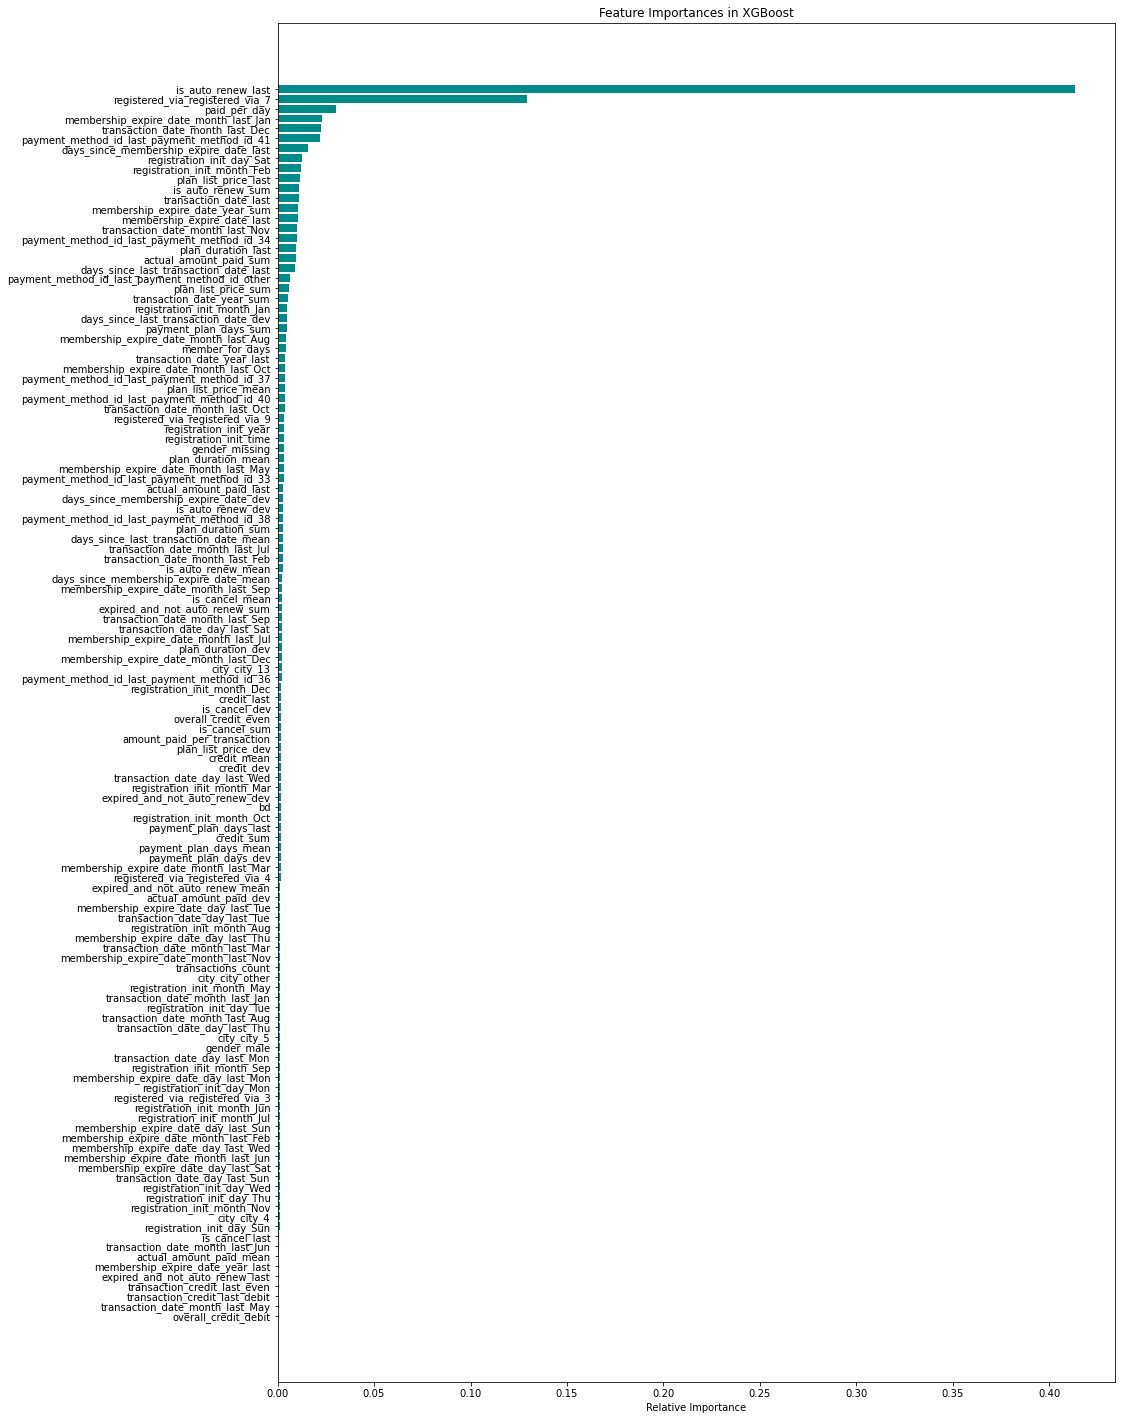

In [39]:
features = X_train_filled.columns
importances = gbm.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,25))

plt.title('Feature Importances in XGBoost')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Hyperparameters tuning

Given that we already have a validation set, we will not use k-fold cross validation. Instead, we'll train on X_train and validate on X_valid for a series of hyperparameters. 
Since the parameters space can be quite large, a randomized search is preferable. To accomplish this with sklearn RandomizedSearchCV, and perform validation on a pre-defined validation set, we will set the RandomizedSearchCV cv parameter to PredefinedSplit: see documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html

In [40]:
# Generate list of indices for train and validation set:
#   -1 for samples to be included in the train set
#    0 for samples to be included in the validation set
my_test_fold = []

for i in range(len(X_train_filled)):
    my_test_fold.append(-1)

for i in range(len(X_valid_filled)):
    my_test_fold.append(0) 
    

# Concatenate the train and validation sets to provide input to RandomizedSearchCV
X = pd.concat([X_train_filled, X_valid_filled], ignore_index=True)
y = pd.concat([y_train, y_valid], ignore_index=True)

In [41]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

clf = XGBClassifier(objective='binary:logistic',
                    eval_metric='logloss',
                    tree_method='hist')

# Run once with same parameters as the previously trained xgb to validate 
# PredefinedSplit is getting the right training and validation indexes
parameters = {'scale_pos_weight':[1]}
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions=parameters,
                                   cv=PredefinedSplit(test_fold=my_test_fold),
                                   n_iter=1,
                                   verbose=3,
                                   refit=False, # to avoid refit on train + valid together
                                   scoring='neg_log_loss',
                                   return_train_score=True,
                                   random_state=42)
random_search.fit(X, y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END scale_pos_weight=1;, score=(train=-0.111, test=-0.144) total time=  15.5s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_chi...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
         

It looks like PredefinedSplit is correctly implemented, we can proceed to hyperparameter tuning.

In [42]:
parameters = {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'gamma' : [0, 2, 5, 10, 20, 50, 100],
              'max_depth': range(1, 21, 1),
              'subsample': [0.7, 0.8, 0.9, 1],
              'min_child_weight': [0.5, 1, 3, 5, 10],
              'n_estimators': [50, 75, 100, 200, 300, 500],
              'scale_pos_weight':[1, 2, 5, 10, 25, 100]
             }

random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions=parameters,
                                   cv=PredefinedSplit(test_fold=my_test_fold),
                                   n_iter=30,
                                   verbose=3,
                                   refit=False, # to avoid refit on train + valid together
                                   scoring='neg_log_loss',
                                   return_train_score=True,
                                   random_state=42)
random_search.fit(X, y)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV 1/1] END gamma=2, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500, scale_pos_weight=10, subsample=0.9;, score=(train=-0.100, test=-0.197) total time= 1.7min
[CV 1/1] END gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=75, scale_pos_weight=2, subsample=0.7;, score=(train=-0.126, test=-0.145) total time=  13.3s
[CV 1/1] END gamma=20, learning_rate=0.1, max_depth=9, min_child_weight=0.5, n_estimators=200, scale_pos_weight=2, subsample=0.9;, score=(train=-0.122, test=-0.142) total time=  36.2s
[CV 1/1] END gamma=5, learning_rate=0.5, max_depth=20, min_child_weight=10, n_estimators=500, scale_pos_weight=1, subsample=0.9;, score=(train=-0.072, test=-0.175) total time= 2.0min
[CV 1/1] END gamma=2, learning_rate=0.1, max_depth=14, min_child_weight=0.5, n_estimators=300, scale_pos_weight=10, subsample=0.7;, score=(train=-0.093, test=-0.183) total time= 1.7min
[CV 1/1] END gamma=0, le

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_chi...
                   n_iter=30,
                   param_distributions={'gamma': [0, 2, 5, 10, 20, 50, 100],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                  

In [43]:
random_search.best_score_

-0.14156491156934897

In [44]:
random_search.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'n_estimators': 500,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 20}

#### Retrain best model

In [45]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        eval_metric='logloss',
                        tree_method='hist',
                        subsample=0.8,
                        scale_pos_weight=1,
                        n_estimators=500,
                        min_child_weight=3,
                        max_depth=3,
                        learning_rate=0.05,
                        gamma=20)
xgb_clf = xgb_clf.fit(X_train_filled, y_train)

In [46]:
y_pred_xgb = xgb_clf.predict(X_valid_filled)
y_pred_proba_xgb = xgb_clf.predict_proba(X_valid_filled)
y_pred_train_xgb = xgb_clf.predict(X_train_filled)
y_pred_proba_train_xgb = xgb_clf.predict_proba(X_train_filled)
print('XGBoost Classifier log-loss train set: ' + str(log_loss(y_train, y_pred_proba_train_xgb[:,1])))
print('XGBoost Classifier log-loss valid set: ' + str(log_loss(y_valid, y_pred_proba_xgb[:,1])))

XGBoost Classifier log-loss train set: 0.11954957394839605
XGBoost Classifier log-loss valid set: 0.14156491156934897


## SMOTE

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
model = XGBClassifier(objective='binary:logistic', 
                        eval_metric='logloss',
                        tree_method='hist')
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

parameters = {'model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'model__gamma' : [0, 2, 5, 10, 20, 50, 100],
              'model__max_depth': range(1, 21, 1),
              'model__subsample': [0.7, 0.8, 0.9, 1],
              'model__min_child_weight': [0.5, 1, 3, 5, 10],
              'model__n_estimators': [50, 75, 100, 200, 300],
              'model__scale_pos_weight':[1, 2, 5]
             }

random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=parameters,
                                   cv=PredefinedSplit(test_fold=my_test_fold),
                                   n_iter=30,
                                   verbose=3,
                                   refit=False, # to avoid refit on train + valid together
                                   scoring='neg_log_loss',
                                   return_train_score=True,
                                   random_state=42)
random_search.fit(X, y)

# Retrain on validation set to predict test set


# Imputation - categorical columns
imputer_most_freq = SimpleImputer(strategy='most_frequent')

X_valid_filled = X_valid.copy()
X_test_filled = X_test.copy()
X_valid_filled[categorical_columns] = pd.DataFrame(imputer_most_freq.fit_transform(X_valid_filled[categorical_columns]))
X_test_filled[categorical_columns] = pd.DataFrame(imputer_most_freq.transform(X_test_filled[categorical_columns]))

# imputation removed column names, put them back
X_valid_filled[categorical_columns].columns = X_valid[categorical_columns].columns
X_test_filled[categorical_columns].columns = X_test[categorical_columns].columns

# convert 'object' to category
X_valid_filled[categorical_columns] = X_valid_filled[categorical_columns].astype('category')
X_test_filled[categorical_columns] = X_test_filled[categorical_columns].astype('category')


# Imputation - numerical columns
imputer_median = SimpleImputer(strategy='median')

X_valid_filled = X_valid_filled.copy()
X_test_filled = X_test_filled.copy()
X_valid_filled[numerical_columns] = pd.DataFrame(imputer_median.fit_transform(X_valid_filled[numerical_columns]))
X_test_filled[numerical_columns] = pd.DataFrame(imputer_median.transform(X_test_filled[numerical_columns]))

# imputation removed column names, put them back
X_valid_filled[numerical_columns].columns = X_valid[numerical_columns].columns
X_test_filled[numerical_columns].columns = X_test[numerical_columns].columns


# one hot encoding
ohe_enc = OneHotEncoder(drop='first')
ohe_enc.fit(X_valid_filled[categorical_columns])
feature_names = ohe_enc.get_feature_names(categorical_columns)
X_valid_filled_ohe = ohe_enc.transform(X_valid_filled[categorical_columns])
X_valid_filled_ohe = pd.DataFrame(X_valid_filled_ohe.todense())
X_valid_filled_ohe.columns = feature_names
X_test_filled_ohe = ohe_enc.transform(X_test_filled[categorical_columns])
X_test_filled_ohe = pd.DataFrame(X_test_filled_ohe.todense())
X_test_filled_ohe.columns = feature_names

X_valid_filled.drop(categorical_columns, axis=1, inplace=True)
X_test_filled.drop(categorical_columns, axis=1, inplace=True)
X_valid_filled = pd.concat([X_valid_filled, X_valid_filled_ohe], axis=1)
X_test_filled = pd.concat([X_test_filled, X_test_filled_ohe], axis=1)

# training
gbm = xgbc.fit(X_valid_filled, y_valid)
y_pred_xgb = gbm.predict(X_test_filled)
y_pred_proba_xgb = gbm.predict_proba(X_test_filled)

test['is_churn'] = y_pred_proba_xgb[:,1].clip(0.+1e-15, 1-1e-15) 
test[['msno','is_churn']].to_csv('Data/Kaggle_Submissions/xgb_sub_scala_trans_and_memb_ohe_retrained_on_validation.csv', index=False)

test[['msno','is_churn']]

In [47]:
## Light GBM

In [48]:
import lightgbm as lgb

lgb_params = {
    'learning_rate': 0.05,
    'application': 'binary',
    'max_depth': 5,
    'num_leaves': 128,
    'verbosity': -1,
    'metric': 'binary_logloss'
}

#x1, x2, y1, y2 =train_test_split(X, y, test_size=0.2, random_state=0)
        
# lgb
d_train = lgb.Dataset(X_train_filled, label=y_train)
d_valid = lgb.Dataset(X_valid_filled, label=y_valid)
watchlist = [d_train, d_valid]

model = lgb.train(lgb_params, 
                  train_set=d_train, 
                  num_boost_round=5000, 
                  valid_sets=watchlist, 
                  early_stopping_rounds=100, 
                  verbose_eval=10)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.135343	valid_1's binary_logloss: 0.16146
[20]	training's binary_logloss: 0.127332	valid_1's binary_logloss: 0.152389
[30]	training's binary_logloss: 0.123783	valid_1's binary_logloss: 0.148798
[40]	training's binary_logloss: 0.121771	valid_1's binary_logloss: 0.146562
[50]	training's binary_logloss: 0.120544	valid_1's binary_logloss: 0.145507
[60]	training's binary_logloss: 0.119678	valid_1's binary_logloss: 0.144781
[70]	training's binary_logloss: 0.119108	valid_1's binary_logloss: 0.144456
[80]	training's binary_logloss: 0.118784	valid_1's binary_logloss: 0.144154
[90]	training's binary_logloss: 0.118508	valid_1's binary_logloss: 0.144005
[100]	training's binary_logloss: 0.1183	valid_1's binary_logloss: 0.143905
[110]	training's binary_logloss: 0.118104	valid_1's binary_logloss: 0.143831
[120]	training's binary_logloss: 0.117942	valid_1's binary_logloss: 0.143712
[130]	training's binary_lo

In [51]:
y_lgb_pred_valid = model.predict(X_valid_filled)
y_lgb_pred_train = model.predict(X_train_filled)
y_lgd_pred_binary = (y_lgb_pred_valid >= 0.5).astype('int8')
y_lgd_pred_binary

print('LGBM Classifier log-loss train set: ' + str(log_loss(y_train, y_lgb_pred_train)))
print('LGBM Classifier log-loss valid set: ' + str(log_loss(y_valid, y_lgb_pred_valid)))

LGBM Classifier log-loss train set: 0.1179684781638866
LGBM Classifier log-loss valid set: 0.143703836660157
